In [1]:
import pandas as pd
import numpy as np
import sqlite3
from datetime import datetime, timezone, timedelta
from custom_process_domain import process_domain_normal
import matplotlib.pyplot as plt
from zoneinfo import ZoneInfo
import seaborn
seaborn.set()



## User Input

In [473]:
POSSIBLE_USERS = { # Just to make sure we're good
  "Juan": "Juan",
  "Nathan": "Nathan",
  "Sanyam": "Sanyam",
  "Nipun": "Nipun",
  "Parsa": "Parsa",
  "Akshita": "Akshita",
}

# User Input
USER = POSSIBLE_USERS["Juan"] # Change this line to one of the names above

# START_DATE
START_DATE_YEAR = 2022
START_DATE_MONTH = 10
START_DATE_DAY = 19

WEEKS_TO_INCREMENT = 0 # Add WEEKS_TO_INCREMENT * 7 days to START_TIME
DATE_INTERVAL_TYPE = 'month' # 'weekend', 'week', 'all_week', 'all_time

##############################
# Graphs
##############################

# Save Graphs
SAVE_GRAPH_1 = False
SAVE_GRAPH_2 = False
SAVE_GRAPH_3 = False
SAVE_GRAPH_4 = False
SAVE_GRAPH_5 = True
SAVE_GRAPH_6 = True

##############################
# Options
##############################
MIN_CHROME_VISIT_DURATION = 5
MAX_CHROME_VISIT_DURATION = 2.88e+10 # 8 hours in microseconds

MIN_SAFARI_SCORE = 5

### Config per User

In [474]:
if USER == "Nathan":
  DB_FILE = "../data/history--2022-10-21--Nathan-Tsai.sqlite3"
  RATING_FILE = "../rated-output/Ratings - CMPT 353 - Nathan Tsai (1).csv"
  USER_TIMEZONE_STRING = 'US/Pacific'
elif USER == "Juan":
  DB_FILE = "../data/history--2022-10-21--Juan-Gonzalez.sqlite3"
  RATING_FILE = "../rated-output/Ratings - CMPT 353 - Juan Gonzalez.csv"
  USER_TIMEZONE_STRING = 'US/Pacific'
elif USER == "Sanyam":
  DB_FILE = "../data/history--2022-11-25--Sanyam-Safari.db"
  RATING_FILE = "../rated-output/Ratings of Inputted Users - CMPT 353 - Sanyam (2).csv"
  USER_TIMEZONE_STRING = 'US/Pacific'
elif USER == "Nipun":
  DB_FILE = "../data/history--2022-11-26--Nipun-Safari.db"
  RATING_FILE = "../rated-output/Ratings of Inputted Users - CMPT 353 - Nipun.csv"
  USER_TIMEZONE_STRING = 'Asia/Colombo' # India standard time: UTC+5:30
elif USER == "Parsa":
  DB_FILE = "../data/history--2022-12-05--Pasha.sqlite3"
  RATING_FILE = "../rated-output/Ratings of Inputted Users - CMPT 353 - Pasha.csv"
  USER_TIMEZONE_STRING = 'Asia/Colombo' # India standard time: UTC+5:30
elif USER == "Akshita":
  DB_FILE = "../data/history--2022-11-25--Akshita-Safari.db"
  RATING_FILE = "../rated-output/Ratings of Inputted Users - CMPT 353 - Akshita.csv"
  USER_TIMEZONE_STRING = 'Asia/Colombo' # India standard time: UTC+5:30
else:
  assert(False and "User name is invalid")

USER_TIMEZONE = ZoneInfo(USER_TIMEZONE_STRING)
TIMEZONE_STRING = USER_TIMEZONE_STRING


START_TIME = datetime(
  START_DATE_YEAR,
  START_DATE_MONTH,
  START_DATE_DAY, 
  tzinfo=USER_TIMEZONE
) # the data to look at. Should be a Monday

# The values per user productivity
productivity_to_int_map = {
  'Always Distracted' : -2,
  'Mostly Distracted' : -1,
  'Neutrel' : 0,
  'Mostly Intentional' : 1,
  'Always Intentional' : 2,
}

## Archive

### Format User Input for Graphs / Files

In [475]:
# Increment by a number of weeks
START_TIME = START_TIME + timedelta(days=7 * WEEKS_TO_INCREMENT)

# Add 1 day if weekend, otherwise use weekday
date_types = {
  'weekend': 1,
  'week': 4,
  'all_week': 6,
  'month': 30,
  'all_time': 7 * 52 * 3, # 3 years
}
DAYS_TO_ADD = date_types[DATE_INTERVAL_TYPE]

if DATE_INTERVAL_TYPE == 'weekend':
  START_TIME = START_TIME + timedelta(days=-2)

END_TIME = START_TIME + timedelta(days=DAYS_TO_ADD)


In [476]:
if DATE_INTERVAL_TYPE == 'all_time':
  start_date_for_graph = START_TIME.strftime('%a, %b %d %Y')
else:
  start_date_for_graph = START_TIME.strftime('%a, %b %d')

  
end_date_for_graph = END_TIME.strftime('%a, %b %d, %Y')
time_for_graph = "{} - {}".format(start_date_for_graph, end_date_for_graph)
CUSTOM_PARAMS_FOR_GRAPH = "{}: {}".format(USER, time_for_graph)

start_date_for_file = START_TIME.strftime('%b-%d-%Y')
end_date_for_file = END_TIME.strftime('%b-%d-%Y')
time_for_file = "{}--{}".format(start_date_for_file, end_date_for_file)
CUSTOM_PARAMS_FOR_FILE = "{}--{}".format(USER, time_for_file)

In [477]:
# Constants
WINDOWS_EPOCH_MICROSECS      = -11644473600000 * 1000
SAFARI_TIME_UPDATE           = 978307200

In [478]:
# Process the type of Database
TYPE_IS_SAFARI = "TYPE_IS_SAFARI"
TYPE_IS_CHROME = "TYPE_IS_CHROME"
TYPE_OF_DB = {
  "db": TYPE_IS_SAFARI,
  "sqlite": TYPE_IS_CHROME,
  "sqlite3": TYPE_IS_CHROME,
}

extension = DB_FILE.split(".")[-1]
DB_TYPE = TYPE_OF_DB[extension]

### Helpful Functions

In [479]:
NUMBER_OF_INCREMENTS = 24 * 2
DAY_IN_SECONDS = 60 * 60 * 24
ROUND_TO = DAY_IN_SECONDS / NUMBER_OF_INCREMENTS

def get_half_hour(data: pd.Series) -> pd.Series:
  return (data / ROUND_TO).round().astype(np.int32)

### Bunch of Processing

#### Load History Database

In [480]:
if DB_TYPE == TYPE_IS_CHROME:
  query_get_urls_and_times = """
  SELECT v.id, v.visit_time, v.visit_duration, u.url
  FROM 'visits' as v 
  LEFT JOIN urls u ON u.id = v.url
  """

  TIME_CORRECTION_TO_ADD_TO_VISIT_TIME = WINDOWS_EPOCH_MICROSECS
elif DB_TYPE == TYPE_IS_SAFARI:
  query_get_urls_and_times = """
  SELECT v.id, v.visit_time, v.score, u.url
  FROM 'history_visits' as v 
  LEFT JOIN history_items u ON u.id = v.history_item
  """
  TIME_CORRECTION_TO_ADD_TO_VISIT_TIME = SAFARI_TIME_UPDATE
else:
  assert(False and "Extension of database is invalid")

In [481]:
with sqlite3.connect(DB_FILE) as con:
  visits = pd.read_sql_query(query_get_urls_and_times, con)

visits.head()

,id,visit_time,visit_duration,url
0,293698,13303114120267367,0,https://mail.sfu.ca/owa/
1,293700,13303162217955155,0,https://mail.sfu.ca/owa/
2,293702,13303245851920431,0,https://mail.sfu.ca/owa/
3,293703,13303247908193105,0,https://canvas.sfu.ca/login/cas
4,293704,13303247908193105,3307842,https://cas.sfu.ca/cas/login?service=https%3A%...


#### Process the time

In [482]:
# Visit time in microseconds (s/1,000,000)
# https://chromium.googlesource.com/chromium/src/+/lkgr/base/time/time.h

if DB_TYPE == TYPE_IS_CHROME:
  visit_time_in_ns = (visits['visit_time'] + TIME_CORRECTION_TO_ADD_TO_VISIT_TIME) * 1000
  visits['visit_time_epoch'] = pd.to_datetime(visit_time_in_ns, unit='ns', utc=True).map(lambda x: x.tz_convert(TIMEZONE_STRING))
elif DB_TYPE == TYPE_IS_SAFARI:
  visit_time_in_ns = (visits['visit_time'] + TIME_CORRECTION_TO_ADD_TO_VISIT_TIME)
  visits['visit_time_epoch'] = pd.to_datetime(visit_time_in_ns, unit='s', utc=True).map(lambda x: x.tz_convert(TIMEZONE_STRING))
else:
  assert(False and "Extension of database is invalid")

#### Process the domains

In [483]:
visits['domain'] = visits['url'].apply(process_domain_normal)

visits

,id,visit_time,visit_duration,url,visit_time_epoch,domain
0,293698,13303114120267367,0,https://mail.sfu.ca/owa/,2022-07-23 22:28:40.267367-07:00,mail.sfu.ca
1,293700,13303162217955155,0,https://mail.sfu.ca/owa/,2022-07-24 11:50:17.955155-07:00,mail.sfu.ca
2,293702,13303245851920431,0,https://mail.sfu.ca/owa/,2022-07-25 11:04:11.920431-07:00,mail.sfu.ca
3,293703,13303247908193105,0,https://canvas.sfu.ca/login/cas,2022-07-25 11:38:28.193105-07:00,canvas.sfu.ca
4,293704,13303247908193105,3307842,https://cas.sfu.ca/cas/login?service=https%3A%...,2022-07-25 11:38:28.193105-07:00,cas.sfu.ca
...,...,...,...,...,...,...
20850,315752,13310844744543288,0,https://www.sans.org/blog/google-chrome-forens...,2022-10-21 09:52:24.543288-07:00,sans.org
20851,315753,13310844744553113,0,https://www.sans.org/blog/google-chrome-forens...,2022-10-21 09:52:24.553113-07:00,sans.org
20852,315754,13310844757937583,0,https://www.google.com/url?q=https://superuser...,2022-10-21 09:52:37.937583-07:00,google.com
20853,315755,13310844758548863,0,https://superuser.com/a/602274,2022-10-21 09:52:38.548863-07:00,superuser.com


In [484]:
visits.tail(n=10)

,id,visit_time,visit_duration,url,visit_time_epoch,domain
20845,315747,13310844738079603,0,https://docs.google.com/document/d/1Q6vay26ubE...,2022-10-21 09:52:18.079603-07:00,docs.google.com
20846,315748,13310844738281019,0,https://docs.google.com/document/d/1Q6vay26ubE...,2022-10-21 09:52:18.281019-07:00,docs.google.com
20847,315749,13310844738290481,0,https://docs.google.com/document/d/1Q6vay26ubE...,2022-10-21 09:52:18.290481-07:00,docs.google.com
20848,315750,13310844739917068,0,https://docs.google.com/document/d/1Q6vay26ubE...,2022-10-21 09:52:19.917068-07:00,docs.google.com
20849,315751,13310844742739820,0,https://www.sans.org/blog/google-chrome-forens...,2022-10-21 09:52:22.739820-07:00,sans.org
20850,315752,13310844744543288,0,https://www.sans.org/blog/google-chrome-forens...,2022-10-21 09:52:24.543288-07:00,sans.org
20851,315753,13310844744553113,0,https://www.sans.org/blog/google-chrome-forens...,2022-10-21 09:52:24.553113-07:00,sans.org
20852,315754,13310844757937583,0,https://www.google.com/url?q=https://superuser...,2022-10-21 09:52:37.937583-07:00,google.com
20853,315755,13310844758548863,0,https://superuser.com/a/602274,2022-10-21 09:52:38.548863-07:00,superuser.com
20854,315756,13310844758548863,0,https://superuser.com/questions/602252/can-chr...,2022-10-21 09:52:38.548863-07:00,superuser.com


#### Load the Ratings

In [485]:
ratings = pd.read_csv(RATING_FILE, index_col='domain')
ratings.head()

,manual_rating,visit_count,sample_url,sample_title
domain,,,,
docs.google.com,Always Intentional,3916,https://docs.google.com/document/u/0/,Google Docs
youtube.com,Mostly Distracted,2996,https://www.youtube.com/,(1) YouTube
google.com,Mostly Intentional,2792,https://www.google.com/maps,Google Maps
tab.gladly.io,Neutrel,2029,https://tab.gladly.io/,Tab for a Cause
ggbaker.ca,Always Intentional,1263,https://ggbaker.ca/data-science/,CMPT 353 Lecture Notes


#### Filter the Data based on Time + Visit Duration/Score

In [486]:
greaterthanStartTime = visits['visit_time_epoch'] >= START_TIME
lessThanEndTime = visits['visit_time_epoch'] <= END_TIME
visits_this_semester = visits[greaterthanStartTime & lessThanEndTime]

In [487]:
if 'visit_duration' in visits_this_semester.columns:
  min_visit_option = visits_this_semester[visits_this_semester['visit_duration'] >= MIN_CHROME_VISIT_DURATION]
  min_visit_option = min_visit_option[min_visit_option['visit_duration'] < MAX_CHROME_VISIT_DURATION]
elif 'score' in visits_this_semester.columns:
  min_visit_option = visits_this_semester[visits_this_semester['score'] >= MIN_SAFARI_SCORE]
else:
  min_visit_option = visits_this_semester

In [488]:

final_data = min_visit_option.join(ratings[['manual_rating']], on="domain", how='left')
final_data['productivity_scale'] = final_data['manual_rating'].map(productivity_to_int_map)
final_data['time_of_day'] = final_data['visit_time_epoch'].dt.hour * 60 * 60 + final_data['visit_time_epoch'].dt.minute * 60 + final_data['visit_time_epoch'].dt.second
final_data.head()

,id,visit_time,visit_duration,url,visit_time_epoch,domain,manual_rating,productivity_scale,time_of_day
19665,314566,13310673863669809,4042430,https://www.youtube.com/watch?v=y3_MFnJKOX4,2022-10-19 10:24:23.669809-07:00,youtube.com,Mostly Distracted,-1.0,37463
19666,314567,13310673867712239,69641,https://www.youtube.com/watch?v=y3_MFnJKOX4&ab...,2022-10-19 10:24:27.712239-07:00,youtube.com,Mostly Distracted,-1.0,37467
19667,314568,13310673867781880,6276732,https://www.youtube.com/watch?v=y3_MFnJKOX4&ab...,2022-10-19 10:24:27.781880-07:00,youtube.com,Mostly Distracted,-1.0,37467
19669,314570,13310673872550876,1841882,https://getadblock.com/en/update/e/5.2.0/?u=qt...,2022-10-19 10:24:32.550876-07:00,getadblock.com,NaN,NaN,37472
19670,314571,13310673874058612,111260,https://www.youtube.com/watch?v=y3_MFnJKOX4,2022-10-19 10:24:34.058612-07:00,youtube.com,Mostly Distracted,-1.0,37474


#### Fill empty productivity scores with 0

In [489]:
# Remove N/A
refined_data = final_data.copy()
refined_data['productivity_scale'] = refined_data['productivity_scale'].fillna(0)

### Graph 1: Productivity

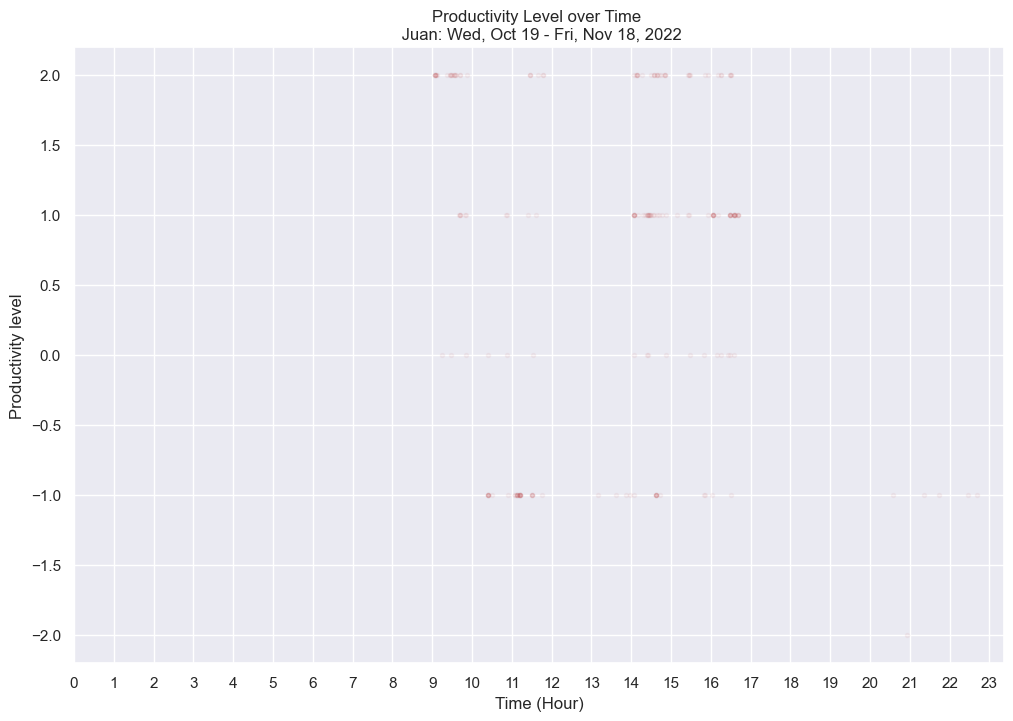

In [490]:
plt.figure(figsize=(12, 8))
plt.plot(refined_data['time_of_day'], refined_data['productivity_scale'], 'r.', alpha=0.05)
plt.xticks(np.arange(0, 60 * 60 * 24, step=60 * 60), np.arange(0, 24, step=1)) # Hours
plt.title("Productivity Level over Time \n {}".format(CUSTOM_PARAMS_FOR_GRAPH))
plt.xlabel("Time (Hour)")
plt.ylabel("Productivity level")
# plt.xticks(np.arange(0, 60 * 60 * 24, step=60 * 30), np.arange(0, 24, step=0.5))

if SAVE_GRAPH_1:
  plt.savefig("../plots/XX-filtered-data--a-week-of-data--{}.png".format(CUSTOM_PARAMS_FOR_FILE))

## Graph 2

### Work for Graph 2: Distracted Analysis

In [491]:
only_distracted = refined_data[refined_data['productivity_scale'] < 0.5].copy()
only_distracted['half_hour'] = get_half_hour(only_distracted['time_of_day'])

only_distracted_agg = only_distracted.groupby('half_hour').agg('sum').reset_index()

### Graph 2

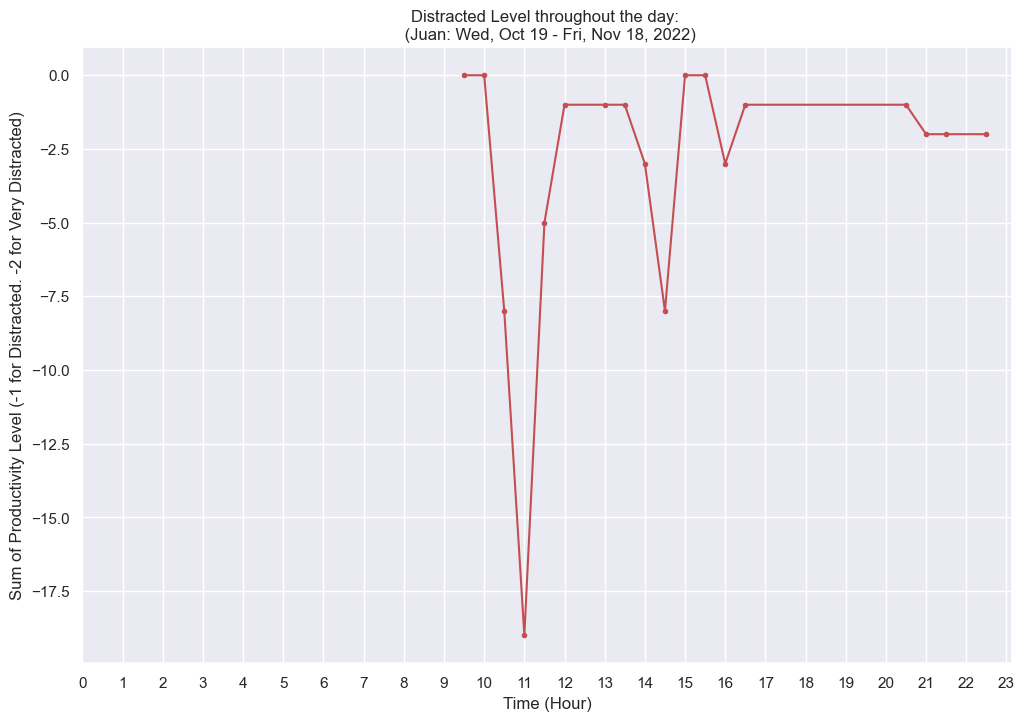

In [492]:
plt.figure(figsize=(12, 8))
plt.plot(only_distracted_agg['half_hour'], only_distracted_agg['productivity_scale'], 'r-')
plt.plot(only_distracted_agg['half_hour'], only_distracted_agg['productivity_scale'], 'r.')
plt.xticks(np.arange(0, 48, 2), np.arange(0, 24, step=1)) # Half Hours
plt.title("Distracted Level throughout the day: \n ({})".format(CUSTOM_PARAMS_FOR_GRAPH))
plt.xlabel("Time (Hour)")
plt.ylabel("Sum of Productivity Level (-1 for Distracted. -2 for Very Distracted)")

if SAVE_GRAPH_2:
  plt.savefig("../plots/XX-filtered-data--a-week-of-data--{}.png".format(CUSTOM_PARAMS_FOR_FILE))

## Graph 3: Account for the visit duration

### Preprocessing (for Chrome only browsers)

In [493]:
if DB_TYPE == TYPE_IS_CHROME:
  adj_prod_pre = refined_data.copy()


In [494]:
if DB_TYPE == TYPE_IS_CHROME:
  # adj_prod = adj_prod_pre
  NUMBER_OF_INCREMENTS = 24 * (60 / 30) # 2 => half hour
  DAY_IN_SECONDS = 60 * 60 * 24
  ROUND_TO = DAY_IN_SECONDS / NUMBER_OF_INCREMENTS

  adj_prod_pre['adjusted_time'] = adj_prod_pre[['visit_duration', 'visit_time_epoch']].apply(
    lambda x: np.arange(0, x['visit_duration'] // 1e6, ROUND_TO) + x['visit_time_epoch'].value // 1e9, axis=1)

  adj_prod = adj_prod_pre.explode('adjusted_time')
  adj_prod.dropna(subset=['adjusted_time'], inplace=True)
else:
  adj_prod = refined_data.copy()


In [495]:
if DB_TYPE == TYPE_IS_CHROME:
  adj_prod['adjusted_datetime'] = pd.to_datetime(adj_prod['adjusted_time'], unit='s', utc=True).map(lambda x: x.tz_convert(TIMEZONE_STRING))

  adj_prod['time_of_day'] = adj_prod['adjusted_datetime'].dt.hour * 60 * 60 \
    + adj_prod['adjusted_datetime'].dt.minute * 60 \
    + adj_prod['adjusted_datetime'].dt.second

In [496]:
adj_prod['half_hour'] = get_half_hour(adj_prod['time_of_day'])

### Graph 3.1: Only Distracted Data

In [497]:
adj_prod_distracted = adj_prod[adj_prod['productivity_scale'] < 0.5]

adj_prod_distracted_agg = adj_prod_distracted.groupby('half_hour').agg('sum').reset_index()


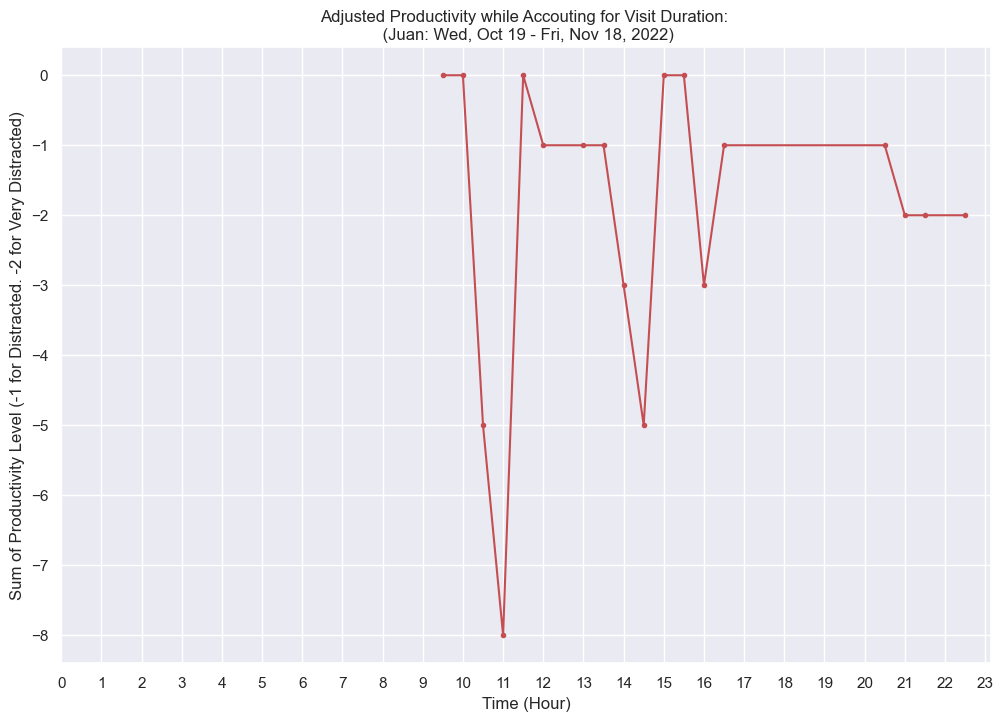

In [498]:
if TYPE_IS_CHROME:
  plt.figure(figsize=(12, 8))
  plt.plot(adj_prod_distracted_agg['half_hour'], adj_prod_distracted_agg['productivity_scale'], 'r-')
  plt.plot(adj_prod_distracted_agg['half_hour'], adj_prod_distracted_agg['productivity_scale'], 'r.')
  plt.xticks(np.arange(0, NUMBER_OF_INCREMENTS, NUMBER_OF_INCREMENTS/24), np.arange(0, 24, step=1)) # Half Hours
  plt.title("Adjusted Productivity while Accouting for Visit Duration: \n ({})".format(CUSTOM_PARAMS_FOR_GRAPH))
  plt.xlabel("Time (Hour)")
  plt.ylabel("Sum of Productivity Level (-1 for Distracted. -2 for Very Distracted)")

  if SAVE_GRAPH_3:
    plt.savefig("../plots/XX-filtered-data--a-week-of-data--{}.png".format(CUSTOM_PARAMS_FOR_FILE))

### Graph 3.2: With Productive Data

In [499]:
adj_prod['adjusted_prod'] = adj_prod['productivity_scale']
positive_sum = adj_prod[adj_prod['productivity_scale'] > 0]['productivity_scale'].sum()
adj_prod.loc[adj_prod['productivity_scale'] > 0, 'adjusted_prod'] /= positive_sum

negative_count = adj_prod[adj_prod['productivity_scale'] < 0]['productivity_scale'].sum()
adj_prod.loc[adj_prod['productivity_scale'] < 0, 'adjusted_prod'] /= -negative_count


In [500]:
adj_prod_agg = adj_prod.groupby('half_hour').agg('sum').reset_index()

START_FOR_GRAPH_4 = 6
END_FOR_GRAPH_4 = 21

adj_prod_agg = adj_prod_agg[
  (adj_prod_agg['half_hour'] >= (START_FOR_GRAPH_4 * 2)) &
  (adj_prod_agg['half_hour'] <= (END_FOR_GRAPH_4 * 2))
]


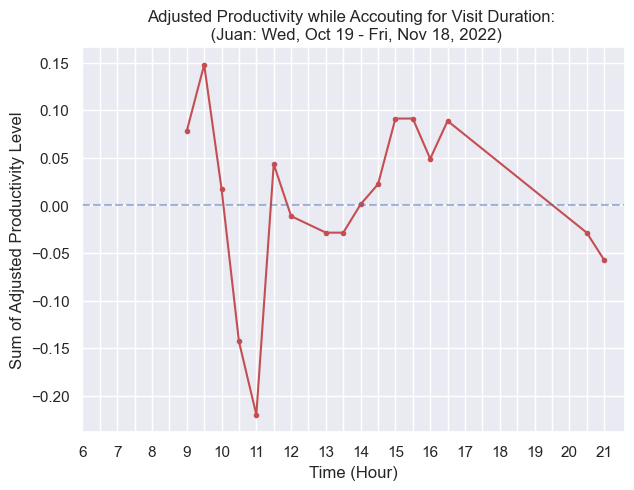

In [501]:
plt.figure(figsize=(7, 5))
plt.plot(adj_prod_agg['half_hour'], adj_prod_agg['adjusted_prod'], 'r-')
plt.plot(adj_prod_agg['half_hour'], adj_prod_agg['adjusted_prod'], 'r.')
# seaborn.lineplot(
#   x='half_hour',
#   y='adjusted_prod',
#   data=adj_prod_agg
# )
plt.axhline(y=0, color='b', linestyle='--', alpha=0.5)
plt.xticks(
  np.arange(START_FOR_GRAPH_4 * 2, END_FOR_GRAPH_4 * 2 + 1, 1), 
  np.arange(START_FOR_GRAPH_4 * 2, END_FOR_GRAPH_4 * 2 + 1, step=1) // 2
) # Half Hours

ax = plt.gca()
for x in ax.xaxis.get_ticklabels()[1::2]:
  x.set_visible(False)

plt.title("Adjusted Productivity while Accouting for Visit Duration: \n ({})".format(CUSTOM_PARAMS_FOR_GRAPH))
plt.xlabel("Time (Hour)")
plt.ylabel("Sum of Adjusted Productivity Level")

if SAVE_GRAPH_4:
  plt.savefig("../plots/XX-filtered-data--a-week-of-data--{}.png".format(CUSTOM_PARAMS_FOR_FILE))

## Graph 4: Final, using Seaborn confidence

In [502]:
resetted_index = adj_prod.reset_index().drop('index', axis=1)

### Graph 4.1: View separately

In [503]:
productive_data_agg = resetted_index[resetted_index['productivity_scale'] >= 0]
# \
#   .groupby('half_hour').agg('sum').reset_index()
  
unproductive_data_agg = resetted_index[resetted_index['productivity_scale'] <= 0]
# \
  # .groupby('half_hour').agg('sum').reset_index()


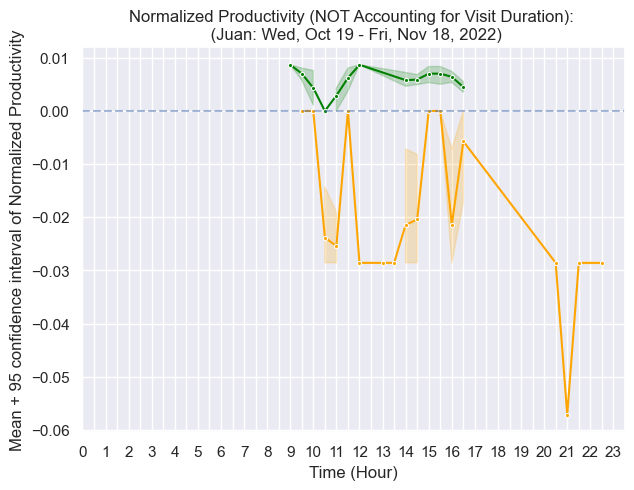

In [504]:
plt.figure(figsize=(7, 5))
seaborn.lineplot(
    x='half_hour',
    y='adjusted_prod',
    data=productive_data_agg,
    color='green',
    marker='.',
)
seaborn.lineplot(
    x='half_hour',
    y='adjusted_prod',
    data=unproductive_data_agg,
    color='orange',
    marker='.',
)
# plt.plot(productive_data_agg['half_hour'], productive_data_agg['adjusted_prod'], 'g-')
# plt.plot(productive_data_agg['half_hour'], productive_data_agg['adjusted_prod'], 'g.')
# plt.plot(unproductive_data_agg['half_hour'], unproductive_data_agg['adjusted_prod'], 'y-')
# plt.plot(unproductive_data_agg['half_hour'], unproductive_data_agg['adjusted_prod'], 'y.')
plt.axhline(y=0, color='b', linestyle='--', alpha=0.5)
plt.xticks(np.arange(0, NUMBER_OF_INCREMENTS, NUMBER_OF_INCREMENTS/48), np.arange(0, 48, step=1)//2) # Half Hours

ax = plt.gca()
for x in ax.xaxis.get_ticklabels()[1::2]:
  x.set_visible(False)

plt.title("Normalized Productivity (NOT Accounting for Visit Duration): \n ({})".format(CUSTOM_PARAMS_FOR_GRAPH))
plt.xlabel("Time (Hour)")
plt.ylabel("Mean + 95 confidence interval of Normalized Productivity")

if SAVE_GRAPH_5:
  plt.savefig("../plots/XX-final-results--confidence-95-separate--{}".format(CUSTOM_PARAMS_FOR_FILE))

In [505]:
adj_prod['adjusted_prod'] = adj_prod['productivity_scale']
positive_sum = adj_prod[adj_prod['productivity_scale'] > 0]['productivity_scale'].sum()
adj_prod.loc[adj_prod['productivity_scale'] > 0, 'adjusted_prod'] /= positive_sum

negative_count = adj_prod[adj_prod['productivity_scale'] < 0]['productivity_scale'].sum()
adj_prod.loc[adj_prod['productivity_scale'] < 0, 'adjusted_prod'] /= -negative_count


### 4.2 View Both Together

In [506]:
START_INCREMENTS_AT = 6 * 2
END_INCREMENTS_AT = 23 * 2

In [507]:
cut_off_data = resetted_index[
  (resetted_index['half_hour'] >= START_INCREMENTS_AT) &
  (resetted_index['half_hour'] <= END_INCREMENTS_AT)
]

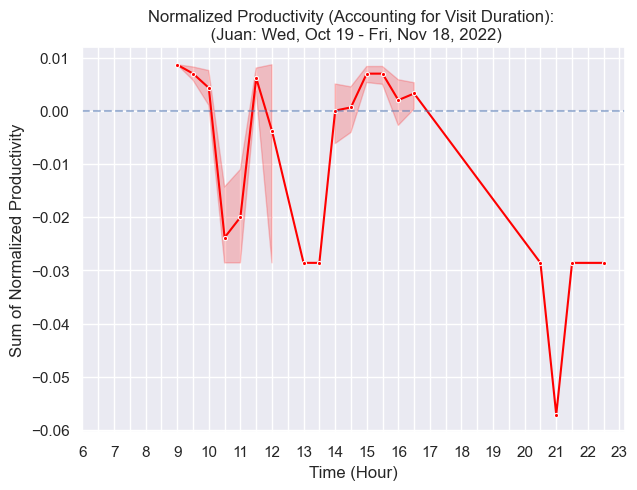

In [508]:
plt.figure(figsize=(7, 5))
seaborn.lineplot(
    x='half_hour',
    y='adjusted_prod',
    data=cut_off_data,
    color='red',
    marker='.',
)
plt.axhline(y=0, color='b', linestyle='--', alpha=0.5)
plt.xticks(
  np.arange(
    START_INCREMENTS_AT, 
    END_INCREMENTS_AT + 1,
    1
  ),
  np.arange(
    START_INCREMENTS_AT,
    END_INCREMENTS_AT + 1,
    step=1
  )//2
) # Half Hours
# plt.xticks(np.arange(0, NUMBER_OF_INCREMENTS, NUMBER_OF_INCREMENTS/48), np.arange(0, 48, step=1)//2) # Half Hours

ax = plt.gca()
for x in ax.xaxis.get_ticklabels()[1::2]:
  x.set_visible(False)

plt.title("Normalized Productivity (Accounting for Visit Duration): \n ({})".format(CUSTOM_PARAMS_FOR_GRAPH))
plt.xlabel("Time (Hour)")
plt.ylabel("Sum of Normalized Productivity")

if SAVE_GRAPH_6:
    plt.savefig("../plots/XX-final-results--confidence-95-together--{}.png".format(CUSTOM_PARAMS_FOR_FILE), bbox_inches='tight')